In [28]:
# importing packages and modules
import pandas as pd 
import numpy as np
from pathlib import Path
import math
import pickle
import matplotlib.pyplot as plt
import scipy.stats as stats
from utils import *
from scipy.stats import multivariate_normal


In [29]:
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
print("True Transition Matrix P")
print(trueP)

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


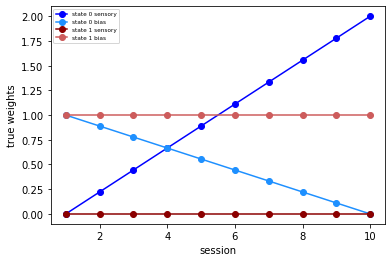

Session indicies
[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


In [30]:
S = 10 # sessions
T = 500 # trials per session
N = T * S
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
plt.plot(range(1,S+1),ourW[:,0,1],color='blue',marker='o',label='state 0 sensory')
plt.plot(range(1,S+1),ourW[:,0,0],color='dodgerblue',marker='o', label='state 0 bias')
plt.plot(range(1,S+1),ourW[:,1,1],color='darkred',marker='o',label='state 1 sensory')
plt.plot(range(1,S+1),ourW[:,1,0],color='indianred',marker='o',label='state 1 bias')
plt.ylabel("true weights")
plt.xlabel('session')
plt.legend(fontsize='xx-small')
plt.show()
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,0] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)


In [31]:
# Iris' code has reversed columns
def emission_probability(x, w,  z=None, latents=False):
    '''
    Calculating emission probabilities for each session

    Parameters
    ----------
    x: N x D numpy array
    z: N x 1 numpy array
    w: N x K x D x C numpy array

    Returns
    -------
    phi: N x K x C numpy array
        emission probabilities
    '''
    N = x.shape[0]
    D = x.shape[1]
    K = w.shape[1]
    phi = np.empty((N,K,C)) # probability that it is state 1
    for k in range(0,K):
        for c in range(0,C):
            phi[:,k,c] = np.exp(-np.sum(w[:,k,:,c]*x,axis=1))
        phi[:,k,:]  = np.divide((phi[:,k,:]).T,np.sum(phi[:,k,:],axis=1)).T     

    return phi

In [32]:
def simulate_data(trueW, trueP,priorZstart,sessInd):
    '''
    function that simulates X and Y data from true weights and true transition matrix
    S sessions, K states, D features (in the order: bias, sensory)
    K = 2 BINOMIAL

    Parameters
    ----------
    trueW: S x K x D numpy array
        true weight matrix
    trueP: K X K numpy array
        true probability transition matrix
    priorZstart: int
        prior for initial latent state to be 0
    sessInd: list of int
        indices of each session start, together with last session end
        
    Returns
    -------
    x_sim: N x D
    y_sim: N x C
    z_sim: 

    '''
    # check that weight and transition matrices are valid options

    n = trueW.shape[0] # total timepoints
    k = trueW.shape[1] # states
    d = trueW.shape[2] # features
    c = trueW.shape[3] # classes
    x = np.empty((n,d))
    y = np.zeros((n,c)).astype(int)
    z = np.empty((n,),dtype=int)

    # input data x
    x[:,0] = 1 # bias term
    x[:,1] = stats.uniform.rvs(loc=-16,scale=33,size=n).astype(int)
    # standardizing sensory info
    x[:,1] = x[:,1] - x[:,1].mean()
    x[:,1] = x[:,1] / x[:,1].std()

    # latent variables z 
    for t in range(0,n):
        if (t in sessInd[:-1]): # beginning of session has a new draw for latent
            z[t] = np.random.binomial(n=1,p=1-priorZstart)
        else:
            z[t] = np.random.binomial(n=1, p=trueP[z[t-1],1])
    
    # observation probabilities
    phi = emission_probability(x, trueW,  z=None, latents=False)

    for t in range(0,n):
        y[t,int(np.random.binomial(n=1,p=phi[t,z[t],1]))]=1

    return x, y, z

xSim, ySim, zSim  = simulate_data(trueW=trueW, trueP=trueP, priorZstart=0.5, sessInd=sessInd)

In [33]:
phiSim = emission_probability(xSim, trueW,  z=None, latents=False)
print(phiSim[3785,0,:])
print(xSim[-3785,:])
print(trueW[-3785,0,:,:])

[0.88927438 0.11072562]
[ 1.         -1.70056743]
[[0.77777778 0.        ]
 [0.44444444 0.        ]]


In [35]:
# Using Iris' code to fit simulate data and calculate alpha forward and backward

# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'glmhmm')))
from glmhmm import glm, glm_hmm, utils
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm import visualize, analysis

true_GLMHMM = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli")
# # compute phi for each state from weights 
phi = np.zeros((true_GLMHMM.n,true_GLMHMM.k,true_GLMHMM.c))
for i in range(true_GLMHMM.n):
    for zi in range(true_GLMHMM.k):
        phi[i,zi,:] = true_GLMHMM.glm.observations.compObs(xSim[i,:],trueW[i,zi,:,:])
# print("Observation prob NxKxC")
# print(phi[:,0,:])

# checked forward and backward passes with Iris' function
# ll_s,alpha_s,alpha_prior_s,cs_s = true_GLMHMM.forwardPass(reshapeObs(ySim[2000:2500,:]),trueP,phiSim[2000:2500,:,:])
# pBack_s,beta_s,zhatBack_s = true_GLMHMM.backwardPass(reshapeObs(ySim[2000:2500,:]),trueP,phiSim[2000:2500,:,:],alpha_s,cs_s)

# inits = 1 # set the number of initializations

# # store values for each initialization
# lls_all = np.zeros((1,250))
# A_all = np.zeros((1,K,K))
# w_all = np.zeros((1,K,D,C))

# fit the model for each initialization
init_p,init_w,_ = true_GLMHMM.generate_params() # initialize the model parameters
#print(init_p)
y0,alpha0,beta0,cs0,A0,phi0,xis0 = true_GLMHMM.fit(reshapeObs(ySim),xSim,init_p,init_w,maxiter=1,sess=sessInd) # fit the model
#print(A_all)



[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]


In [36]:
print(xis0[0:499])

[[[0.08208902 0.09934092]
  [0.05245989 0.11064887]]

 [[0.51414745 0.29804239]
  [0.31253325 0.3157643 ]]

 [[0.63689809 0.25923439]
  [0.47930315 0.34002387]]

 ...

 [[0.05740243 0.06386217]
  [0.06898455 0.13376473]]

 [[0.60083862 0.31185643]
  [0.35975881 0.32545036]]

 [[0.25593946 0.0998787 ]
  [0.1814811  0.12343647]]]


In [37]:
print(xis1[0:499])

NameError: name 'xis1' is not defined

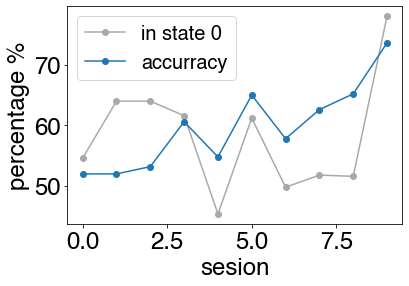

In [35]:
perf,ind = accuracy(xSim,ySim,zSim,s=10)

In [38]:
# already checked with Iris' function that it is correct
def forward_pass(y,P,phi,pi0=None):
    '''
    Calculates alpha scaled as part of the forward-backward algorithm in E-step for a single session 
    given current parameters weight w and transition matrix P

    Parameters
    ----------
    y : Tx1 vector of observations with values 0,1,..,C-1
    P : KxK matrix of transition probabilities
    phi : TxKxC matrix of emission probabilities
        
    Returns
    -------
    ll : float, marginal log-likelihood of the data p(y)
    alpha : nx1 vector of the conditional probabilities p(z_t|x_{1:t},y_{1:t})
    ct : nx1 vector of the forward marginal likelihoods p(y_t | y_1:t-1)
    '''
    T = y.shape[0]
    K = P.shape[0]
    
    alpha = np.zeros((T,K)) # forward probabilities p(z_t | y_1:t)
    alpha_prior = np.zeros((T,K)) # prior probabilities p(z_t | y_1:t-1)
    lt = np.zeros((T,K)) # likelihood of data p(y_t|z_t)
    ct = np.zeros(T) # forward marginal likelihoods p(y_t | y_1:t-1)

    # forward pass calculations
    for t in range(0,T):
        lt[t,:] = phi[t,:,y[t]] # likelihood p(y_t | z_t)
        if (t==0): # time point 0
            if (pi0==None):
                alpha_prior[0,:] = np.ones((1,K))/K # prior of z_0 before any data (=uniform)
            else:
                alpha_prior[0,:] = pi0
        else:
            alpha_prior[t,:] = (alpha[t-1,:].T @ P) # conditional p(z_t | y_1:t-1)
        pxz = np.multiply(lt[t],alpha_prior[t,:]) # joint P(y_1:t,z_t)
        ct[t] = np.sum(pxz) # conditional p(y_t | y_1:t-1)
        alpha[t,:] = pxz/ct[t] # conditional p(z_t | y_1:t)
    
    ll = np.sum(np.log(ct)) # marginal log likelihood p(y_1:T) as sum of log conitionals p(y_t | y_1:t-1) 
    
    return alpha,alpha_prior,ct,ll

alpha,alpha_prior,ct,ll = forward_pass(reshapeObs(ySim[2000:2500,:]),trueP,phiSim[2000:2500,:,:])



In [39]:
# already checked with Iris' function that it is correct
def backward_pass(y,P,phi,ct,pi0=None):
    '''
    Calculates beta scaled as part of the forward-backward algorithm in E-step for a single session 
    given current parameters weight w and transition matrix P

    Parameters
    ----------
    y : Tx1 vector of observations with values 0,1,..,C-1
    P : KxK matrix of transition probabilities
    phi : TxKxC matrix of emission probabilities
    ct : Tx1 numpy vector of forward marginal likelihoods p(y_t | y_1:t-1), calculated at forward_pass
        
    Returns
    -------
    beta: TxK numpy array 
    
    '''
    T = y.shape[0]
    K = P.shape[0]
    
    beta = np.zeros((T,K)) # backward conditional probabilities p(y_t+1:T | z_t)/p(y_t+1:T | y_1:t)
    lt = np.zeros((T,K)) # likelihood of data p(y_t|z_t)

    # last time point
    beta[-1] = 1 # p(z_T=1)

    # backward pass calculations
    for t in np.arange(T-2,-1,-1):
        lt[t+1,:] = phi[t+1,:,y[t+1]] 
        beta[t,:] = P @ (np.multiply(beta[t+1,:],lt[t+1,:]))
        beta[t,:] = beta[t,:] / ct[t+1] # scaling factor
    
    return beta
beta = backward_pass(reshapeObs(ySim[2000:2500,:]),trueP,phiSim[2000:2500,:,:],ct)

In [40]:
# checked gamma, still have to check zeta
def posteriorLatents(y, p, phi, alpha, beta, ct):
    ''' 
    calculates marginal posterior of latents gamma(z_t) = p(z_t | y_1:T)
    and joint posterior of successive latens zeta(z_t,z_t+1) = p(z_t,z_t+1 | y_1:T)

    Parameters
    ----------
    y : Tx1 vector of observations with values 0,1,..,C-1
    '''
    N = phi.shape[0]
    K = phi.shape[1]
    C = phi.shape[2]
    T = ct.shape[0]
    gamma = np.empty((T,K)).astype(float) # marginal posterior of latents
    zeta = np.empty((T-1,K,K)).astype(float)

    gamma = np.multiply(alpha,beta) # gamma(z_t) = alpha(z_t) * beta(z_t)
    
    for t in range(0,T-1):#T-1):
        alpha_beta = alpha[t,:].reshape((K,1)) @ beta[t+1,:].reshape((1,K))
        zeta[t,:,:] = np.multiply(alpha_beta,p) 
        zeta[t,:,:] = np.multiply(zeta[t,:,:],phi[t+1,:,y[t+1]]) # changed t+1 to t in phi to match Iris'
        zeta[t,:,:] = zeta[t,:,:] / ct[t+1]
    return gamma, zeta
gamma, zeta = posteriorLatents(reshapeObs(ySim[2000:2500,:]), trueP, phiSim[2000:2500,:], alpha, beta, ct)



In [59]:
def weight_log_like(currentW, x, y, gamma, prevW, nextW, sigma):
    '''
    log likelihood function to optimize the weight in M-step

    Parameters
    ----------
    currentW: K x D  vector
        only weights correspind to one current session for C=0
    prevW: K x D x C vector
        weights previous session
    nextW: K x D x C vector
        weights next session
    '''
    T = x.shape[0]
    K = currentW.shape[0]
    D = currentW.shape[1]
    C = prevW.shape[2]
    sessW = np.zeros((T,K,D,C))
    for t in range(0,T):
        sessW[t,:,:,0] = currentW[:,:]
    phi = emission_probability(x, sessW,  z=None, latents=False) # N x K x C matrix
    K = phi.shape[1]
    ll = 0

    for t in range(0,T):
        ll += np.multiply(gamma[t,:],np.log(phi[t,:,y[t]])).sum()
    
    # w | prevW ~ Normal(prevW, sigma^2*Id) and w | nextW ~ Normal(nextW, sigma^2*Id)
    for k in range(0,K):
        if (prevW is not None):
            rv = multivariate_normal(mean=prevW[k,:,0], cov=np.diag(np.square(sigma[k,:])))
            ll += np.log(rv.pdf(currentW[k,:]))   
        if (nextW is not None):
            rv = multivariate_normal(mean=nextW[k,:,0], cov=np.diag(np.square(sigma[k,:])))
            ll += np.log(rv.pdf(currentW[k,:]))
            
    
    return ll
weight_log_like(trueW[500,:,:,0], xSim[0:500], reshapeObs(ySim[0:500]), gamma,trueW[0],trueW[1000], reshapeSigma(0.5,2,2))

-303.2655802296192

In [27]:
ourSigma = reshapeSigma(sigma=1,K=K,D=D)
def fit(y, x, initP, initW, sigma=ourSigma, pi0=None, maxIter=250, tol=1e-3, sessInd=None):
    '''
    Fitting function based on EM algorithm

    Parameters
    ----------
    y : NxC vector of observations with values 0 and 1, and exactly one 1 per row
    initP : KxK numpy array
        initial matrix of transition probabilities
    initW: NxKxDxC numpy array
        initial weight matrix
    sigma: 1x1 or Kx1 or 1xD or KxD matrix
        covariance of weight drifting over sessions

    pi0 : initial kx1 vector of state probabilities for t=1.
    maxiter : int
         The maximum number of iterations of EM to allow. The default is 250.
    tol : float
        The tolerance value for the loglikelihood to allow early stopping of EM. The default is 1e-3.
    sessions : an optional vector of the first and last indices of different sessions in the data (for separate computations of the E step; first and last entries should be 0 and n, respectively)  
    
    Returns
    -------
    '''
    n = initW.shape[0] # total timepoints
    k = initW.shape[1] # states
    d = initW.shape[2] # features
    c = initW.shape[3] # classes
    sess = len(sessInd)-1
    zeta = np.zeros((n-1,K,K)).astype(float)
    y = reshapeObs(y) 

    if sess is None:
        sess = [0,n] # equivalent to saying the entire data set has one session

    # initialize w and P 
    w = np.copy(initW)
    p = np.copy(initP)

    for n in range(maxIter):
        print("Iter")
         
        # calculate emission probabilities given theta_old
        phi_original = emission_probability(x, w,  z=None, latents=False)
        phi[:,:,[0,1]] = phi_original[:,:,[1,0]]

        ll = 0

        # EM step for each session independently 
        for s in range(0,sess-1):
            
            # E step - calculates all probabilities given theta_old = previous weight and transition matrix p
            alphaSess, _, ctSess, llSess = forward_pass(y[sessInd[s]:sessInd[s+1]],p,phi[sessInd[s]:sessInd[s+1],:,:])
            betaSess = backward_pass(y[sessInd[s]:sessInd[s+1]],p,phi[sessInd[s]:sessInd[s+1],:,:],ctSess)
            gammaSess, zetaSess = posteriorLatents(y[sessInd[s]:sessInd[s+1]],p,phi[sessInd[s]:sessInd[s+1],:,:], alphaSess, betaSess, ctSess)

            # merging info for all sessions 
            zeta[sessInd[s]:sessInd[s+1]-1,:,:] = zetaSess[:,:,:] 
            ll += llSess
            
            # M step for weights - weights are updated for each session individually (as neighboring session weights have to be fixed)

       
        # M-step for transition matrix p - for all sessions together
        # Closed form update 
        # for i in range(0,K):
        #     for j in range(0,K):
        #         p[i,j] = zeta[:,i,j].sum()/zeta[:,i,:].sum()
    
    return w, p, zeta
    #return y,alphaSess,betaSess,ctSess,p,phi,zeta,gammaSess
initP = init_p
initW = np.empty((N,K,D,C))
for i in range(0,N):    
    initW[i,:,:,:] = np.copy(init_w)
y1,alpha1,beta1,cs1,A1,phi1,xis1,gamma = fit(ySim,xSim,initP,initW,maxIter=1,tol=1e-3,sessInd=sessInd)



NameError: name 'init_p' is not defined

In [26]:
def reshapeSigma(sigma, K, D):
    ''' 
    changing variance parameter sigma to have shape KxD

    Parameters
    ----------
    sigma: nonnegative floats
        either scalar, Kx1, 1xD, or KxD numpy array

    Returns
    -------
    newSigma: KxD numpy array
    '''
    newSigma = np.empty((K,D))
    if (isinstance(sigma, float)  == True) or isinstance(sigma, int)  == True:
        newSigma.fill(sigma)
    elif (sigma.shape[0]==1 and sigma.shape[1]==D):
        newSigma = np.repeat(sigma, repeats = K, axis=0)
    elif (sigma.shape[0]==K and sigma.shape[1]==1):
        newSigma = np.repeat(sigma, repeats = D, axis=1)
    elif (sigma.shape[0]==K and sigma.shape[1]==D):
        newSigma = np.copy(sigma)
    else:
        raise Exception('sigma can only be scalar, Kx1, 1xD, or KxD numpy array')
    
    # add check of nonnegative elements

    return newSigma
print(reshapeSigma(sigma=np.array([1,2]).reshape((2,1)),K=2,D=2))
    


[[1 1]
 [2 2]]


In [ ]:
    def fit(self,y,x,A,w,pi0=None,fit_init_states=False,maxiter=250,tol=1e-3,sess=None,B=1):
        '''
        Parameters
        ----------
        y : nx1 vector of observations 
        A : initial kxk matrix of transition probabilities
        phi : initial kxc or nxkxc matrix of emission probabilities
        pi0 : initial kx1 vector of state probabilities for t=1.
        fit_init_states : boolean, determines if EM will including fitting pi
        maxiter : int. The maximum number of iterations of EM to allow. The default is 250.
        tol : float. The tolerance value for the loglikelihood to allow early stopping of EM. The default is 1e-3.
        sessions : an optional vector of the first and last indices of different sessions in the data (for
        separate computations of the E step; first and last entries should be 0 and n, respectively)  
        B : an optional temperature parameter used when fitting via direct annealing EM (DAEM; see Ueda and Nakano 1998)                                                                                         
        Returns
        -------
        lls : vector of loglikelihoods for each step of EM, size maxiter 
        A : fitted kxk matrix of transition probabilities
        w : fitted kxdxc omatrix of weights
        pi0 : fitted kx1 vector of state probabilities for t= (only different from initial value of fit_init_states=True)
        '''
        
        self.lls = np.empty(maxiter)
        self.lls[:] = np.nan
            
        # store variables
        self.pi0 = pi0
        
        # # compute phi for each state from weights 
        phi = np.zeros((self.n,self.k,self.c))
        for i in range(self.n):
            for zi in range(self.k):
                phi[i,zi,:] = self.glm.observations.compObs(x[i,:],w[zi,:,:])
        
        if sess is None:
            sess = np.array([0,self.n]) # equivalent to saying the entire data set has one session
        
        for n in range(maxiter):
            
            # E STEP
            alpha = np.zeros((self.n,self.k))
            beta = np.zeros_like(alpha)
            cs = np.zeros((self.n))
            self.pStates = np.zeros_like(alpha)
            self.states = np.zeros_like(cs)
            ll = 0
            
            for s in range(len(sess)-1): # compute E step separately over each session or day of data 
                ll_s,alpha_s,_,cs_s = self.forwardPass(y[sess[s]:sess[s+1]],A,phi[sess[s]:sess[s+1],:,:],pi0=pi0)
                pBack_s,beta_s,zhatBack_s = self.backwardPass(y[sess[s]:sess[s+1]],A,phi[sess[s]:sess[s+1],:,:],alpha_s,cs_s)
                
                
                ll += ll_s
                alpha[sess[s]:sess[s+1]] = alpha_s
                cs[sess[s]:sess[s+1]] = cs_s
                self.pStates[sess[s]:sess[s+1]] = pBack_s ** B
                beta[sess[s]:sess[s+1]] = beta_s
                self.states[sess[s]:sess[s+1]] = zhatBack_s
                
            
            self.lls[n] = ll
            
            # M STEP
            A,w,phi,pi0 = self._updateParams(y,x,self.pStates,beta,alpha,cs,A,phi,w,fit_init_states = fit_init_states)
            
            
            # CHECK FOR CONVERGENCE    
            self.lls[n] = ll
            if  n > 5 and self.lls[n-5] + tol >= ll: # break early if tolerance is reached
                break
        
        self.A,self.w,self.phi,self.pi0 = A,w,phi,pi0

        return self.lls,self.A,self.w,self.pi0

In [17]:
# to check reshape Obs for C>=3